In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np
import os
from tqdm import tqdm
from PIL import Image

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

In [2]:
def read_annotation_file(path):
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict

train_annotation = read_annotation_file('train_anno.json')
len(train_annotation)

1280

In [3]:
for i in range(1, 1281):    
    if len(train_annotation[i][1]) == 0:
        del train_annotation[i]
        
anno_len = len(train_annotation)
anno_len

955

In [4]:
random.seed(0)
train_split = random.sample(train_annotation.keys(), int(0.8 * anno_len))
valid_split = [i for i in train_annotation.keys() if i not in train_split]

In [5]:
radius = 3

class spotGEODataset(Dataset):
    def __init__(self, root, image_ids=train_annotation.keys(), transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = []
        self.idx_mapping = []
        for im in image_ids:
            for fr in range(1, 6):
                self.imgs.append('{}/{}.png'.format(im, fr))
                self.idx_mapping.append((im, fr))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path)
        
        im, fr = self.idx_mapping[idx]
        num_objs = len(train_annotation[im][fr])
        
        boxes = []
        for coor in train_annotation[im][fr]:
            coor = [x + .5 for x in coor]
            xmin = max(coor[0] - radius, 0)
            xmax = min(coor[0] + radius, 640)
            ymin = max(coor[1] - radius, 0)
            ymax = min(coor[1] + radius, 480)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
dataset = spotGEODataset('train')
dataset[0]

(<PIL.PngImagePlugin.PngImageFile image mode=L size=640x480 at 0x1177AE0F448>,
 {'boxes': tensor([[499.9062, 234.6146, 505.9062, 240.6146],
          [487.8818, 219.3115, 493.8818, 225.3115],
          [138.3743, 126.5936, 144.3743, 132.5936]]),
  'labels': tensor([1, 1, 1]),
  'image_id': tensor([0]),
  'area': tensor([36., 36., 36.]),
  'iscrowd': tensor([0, 0, 0])})

In [7]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
train_dataset = spotGEODataset('train', train_split, transforms=get_transform(train=True))
valid_dataset = spotGEODataset('train', valid_split, transforms=get_transform(train=False))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=utils.collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=utils.collate_fn
)

In [9]:
def showBbox(sample, boxes, scores=[]):
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(12,16))

    # Display the image
    ax.imshow(sample, cmap='gray')

    for i in range(len(boxes)):
        # Create a Rectangle patch
        box = boxes[i]
        rect = patches.Rectangle((box[0], box[1]),
                                 2*radius, 2*radius,
                                 linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        if len(scores) != 0:
            # Add score annotation
            score = scores[i]
            ax.annotate('%.2f'%(score), (box[0], box[1]), (box[0] - 2*radius, box[1] - radius), color='w')

    ax.set_axis_off()
    plt.show()

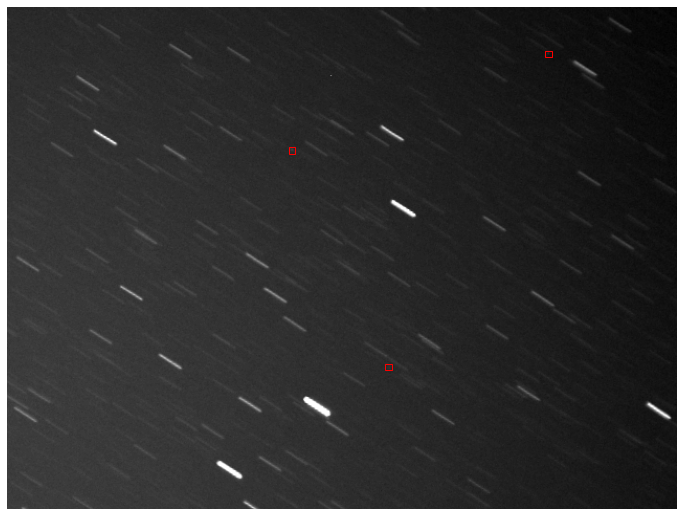

In [10]:
images, targets = next(iter(train_data_loader))
boxes = targets[0]['boxes'].numpy().astype(np.int32)
sample = np.array(images[0]).reshape(480, 640)
showBbox(sample, boxes)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    print('='*50)
    print('EPOCH', epoch + 1)
    print('='*50)
    # train for one epoch, printing every 100 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)
    # save model
    torch.save(model.state_dict(), 'model_fasterrcnn-resnet50-fpn_{}-epochs.pt'.format(epoch))
    print()

EPOCH 1


C:\Users\User\.conda\envs\env_pytorch\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch: [0]  [  0/955]  eta: 1:42:00  lr: 0.000010  loss: 8.5846 (8.5846)  loss_classifier: 0.6754 (0.6754)  loss_box_reg: 0.0007 (0.0007)  loss_objectness: 7.3363 (7.3363)  loss_rpn_box_reg: 0.5722 (0.5722)  time: 6.4090  data: 0.0300  max mem: 3993
Epoch: [0]  [100/955]  eta: 0:19:32  lr: 0.000534  loss: 0.2374 (1.0289)  loss_classifier: 0.0538 (0.1528)  loss_box_reg: 0.0183 (0.0250)  loss_objectness: 0.1039 (0.6725)  loss_rpn_box_reg: 0.0606 (0.1786)  time: 1.2952  data: 0.0407  max mem: 3993
Epoch: [0]  [200/955]  eta: 0:16:51  lr: 0.001057  loss: 0.3163 (0.6878)  loss_classifier: 0.0562 (0.1072)  loss_box_reg: 0.0271 (0.0292)  loss_objectness: 0.1255 (0.4156)  loss_rpn_box_reg: 0.0816 (0.1358)  time: 1.3159  data: 0.0445  max mem: 3993
Epoch: [0]  [300/955]  eta: 0:14:31  lr: 0.001581  loss: 0.1787 (0.5469)  loss_classifier: 0.0354 (0.0869)  loss_box_reg: 0.0201 (0.0288)  loss_objectness: 0.0538 (0.3168)  loss_rpn_box_reg: 0.0645 (0.1144)  time: 1.3110  data: 0.0405  max mem: 3993


Test:  [400/478]  eta: 0:00:21  model_time: 0.2590 (0.2617)  evaluator_time: 0.0020 (0.0024)  time: 0.2754  data: 0.0092  max mem: 3993
Test:  [477/478]  eta: 0:00:00  model_time: 0.2600 (0.2614)  evaluator_time: 0.0020 (0.0024)  time: 0.2680  data: 0.0084  max mem: 3993
Test: Total time: 0:02:11 (0.2752 s / it)
Averaged stats: model_time: 0.2600 (0.2614)  evaluator_time: 0.0020 (0.0024)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.743
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.531
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | m

Epoch: [3]  [800/955]  eta: 0:03:20  lr: 0.000500  loss: 0.0763 (0.1129)  loss_classifier: 0.0170 (0.0230)  loss_box_reg: 0.0054 (0.0071)  loss_objectness: 0.0239 (0.0563)  loss_rpn_box_reg: 0.0184 (0.0265)  time: 1.2938  data: 0.0205  max mem: 3993
Epoch: [3]  [900/955]  eta: 0:01:11  lr: 0.000500  loss: 0.0892 (0.1132)  loss_classifier: 0.0240 (0.0233)  loss_box_reg: 0.0058 (0.0072)  loss_objectness: 0.0281 (0.0562)  loss_rpn_box_reg: 0.0257 (0.0265)  time: 1.2924  data: 0.0203  max mem: 3993
Epoch: [3]  [954/955]  eta: 0:00:01  lr: 0.000500  loss: 0.0569 (0.1123)  loss_classifier: 0.0117 (0.0232)  loss_box_reg: 0.0049 (0.0073)  loss_objectness: 0.0232 (0.0554)  loss_rpn_box_reg: 0.0190 (0.0264)  time: 1.2933  data: 0.0204  max mem: 3993
Epoch: [3] Total time: 0:20:36 (1.2950 s / it)
creating index...
index created!
Test:  [  0/478]  eta: 0:02:13  model_time: 0.2680 (0.2680)  evaluator_time: 0.0010 (0.0010)  time: 0.2790  data: 0.0070  max mem: 3993
Test:  [100/478]  eta: 0:01:45  mo

Epoch: [5]  [200/955]  eta: 0:16:19  lr: 0.000500  loss: 0.0857 (0.1143)  loss_classifier: 0.0193 (0.0239)  loss_box_reg: 0.0053 (0.0067)  loss_objectness: 0.0390 (0.0583)  loss_rpn_box_reg: 0.0239 (0.0255)  time: 1.2981  data: 0.0216  max mem: 3993
Epoch: [5]  [300/955]  eta: 0:14:13  lr: 0.000500  loss: 0.0581 (0.1044)  loss_classifier: 0.0146 (0.0226)  loss_box_reg: 0.0033 (0.0065)  loss_objectness: 0.0211 (0.0508)  loss_rpn_box_reg: 0.0199 (0.0245)  time: 1.3016  data: 0.0254  max mem: 3993
Epoch: [5]  [400/955]  eta: 0:12:02  lr: 0.000500  loss: 0.0686 (0.1030)  loss_classifier: 0.0173 (0.0218)  loss_box_reg: 0.0051 (0.0064)  loss_objectness: 0.0216 (0.0509)  loss_rpn_box_reg: 0.0205 (0.0240)  time: 1.2978  data: 0.0251  max mem: 3993
Epoch: [5]  [500/955]  eta: 0:09:51  lr: 0.000500  loss: 0.0668 (0.1016)  loss_classifier: 0.0149 (0.0221)  loss_box_reg: 0.0042 (0.0067)  loss_objectness: 0.0254 (0.0487)  loss_rpn_box_reg: 0.0201 (0.0242)  time: 1.2978  data: 0.0255  max mem: 3993



EPOCH 8
Epoch: [7]  [  0/955]  eta: 0:20:33  lr: 0.000050  loss: 0.0857 (0.0857)  loss_classifier: 0.0223 (0.0223)  loss_box_reg: 0.0058 (0.0058)  loss_objectness: 0.0369 (0.0369)  loss_rpn_box_reg: 0.0207 (0.0207)  time: 1.2920  data: 0.0240  max mem: 3993
Epoch: [7]  [100/955]  eta: 0:18:24  lr: 0.000050  loss: 0.0444 (0.1008)  loss_classifier: 0.0100 (0.0234)  loss_box_reg: 0.0022 (0.0067)  loss_objectness: 0.0192 (0.0469)  loss_rpn_box_reg: 0.0134 (0.0238)  time: 1.2944  data: 0.0226  max mem: 3993
Epoch: [7]  [200/955]  eta: 0:16:16  lr: 0.000050  loss: 0.0756 (0.1016)  loss_classifier: 0.0177 (0.0228)  loss_box_reg: 0.0051 (0.0067)  loss_objectness: 0.0256 (0.0481)  loss_rpn_box_reg: 0.0230 (0.0240)  time: 1.2943  data: 0.0223  max mem: 3993
Epoch: [7]  [300/955]  eta: 0:14:07  lr: 0.000050  loss: 0.0631 (0.0942)  loss_classifier: 0.0161 (0.0218)  loss_box_reg: 0.0034 (0.0065)  loss_objectness: 0.0207 (0.0428)  loss_rpn_box_reg: 0.0182 (0.0230)  time: 1.2941  data: 0.0203  max m

Test:  [300/478]  eta: 0:00:50  model_time: 0.2690 (0.2660)  evaluator_time: 0.0020 (0.0027)  time: 0.2835  data: 0.0095  max mem: 3993
Test:  [400/478]  eta: 0:00:22  model_time: 0.2710 (0.2689)  evaluator_time: 0.0030 (0.0030)  time: 0.3005  data: 0.0124  max mem: 3993
Test:  [477/478]  eta: 0:00:00  model_time: 0.2740 (0.2713)  evaluator_time: 0.0020 (0.0030)  time: 0.2943  data: 0.0125  max mem: 3993
Test: Total time: 0:02:17 (0.2877 s / it)
Averaged stats: model_time: 0.2740 (0.2713)  evaluator_time: 0.0020 (0.0030)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.628
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.739
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.628
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Ave

In [15]:
model.to(device)
model.load_state_dict(torch.load('model_fasterrcnn-resnet50-fpn_6-epochs.pt'))

<All keys matched successfully>

In [16]:
# put the model in evaluation mode

model.eval()

prediction = []
for im in tqdm(range(1, 5121)):
    for fr in range(1, 6):
        img_path = os.path.join('test', str(im), str(fr) + '.png')
        img = plt.imread(img_path).reshape(1, 480, 640)
        img = torch.tensor(img)
        with torch.no_grad():
            prediction += model([img.to(device)])
    
prediction

100%|████████████████████████████████████████████████████████████████████████████| 5120/5120 [1:07:49<00:00,  1.26it/s]


[{'boxes': tensor([[490.5060, 258.9033, 496.4886, 264.8856],
          [459.7438,  54.9016, 465.7696,  60.9418],
          [ 46.8255, 425.1133,  52.8278, 431.0223],
          [615.0008, 328.5294, 621.0472, 334.6494],
          [635.7076, 313.1349, 640.0000, 319.4188],
          [590.3500, 226.5415, 596.3618, 232.7426],
          [569.0749, 233.2611, 574.9316, 239.2623],
          [254.1589, 155.2451, 260.1270, 161.1742],
          [563.7963, 392.4342, 569.5922, 398.4164],
          [587.7538, 226.9696, 593.8682, 233.2710],
          [571.2088, 232.1035, 577.2639, 238.2525],
          [635.2168, 140.4037, 640.0000, 146.3050],
          [582.6146, 386.3028, 588.4352, 392.3170]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9981, 0.9710, 0.9606, 0.9477, 0.7393, 0.4365, 0.2195, 0.1356, 0.1269,
          0.1073, 0.0798, 0.0747, 0.0612], device='cuda:0')},
 {'boxes': tensor([[515.6724, 232.9583, 521.6937, 238.9424],
   

In [17]:
torch.save(prediction, 'prediction_fasterrcnn-resnet50-fpn_6-epochs.pt')

In [18]:
all_scores = []
for pred in prediction:
    for score in pred['scores']:
        all_scores.append(torch.IntTensor.item(score))

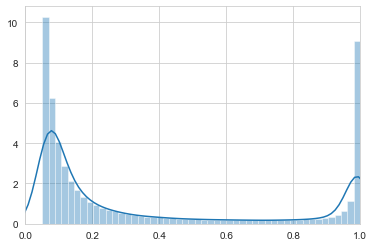

In [20]:
import seaborn as sns
sns.set_style("whitegrid")

sns.distplot(all_scores, bins=50)
plt.xlim((0., 1.))
plt.show()

In [26]:
prediction_cut = prediction.copy()
score_thres = 0.8
for pred in prediction_cut:
    pred['boxes'] = pred['boxes'][pred['scores'] > score_thres, :]
    pred['labels'] = pred['labels'][pred['scores'] > score_thres]
    pred['scores'] = pred['scores'][pred['scores'] > score_thres]

prediction_cut

[{'boxes': tensor([[490.5060, 258.9033, 496.4886, 264.8856],
          [459.7438,  54.9016, 465.7696,  60.9418],
          [ 46.8255, 425.1133,  52.8278, 431.0223],
          [615.0008, 328.5294, 621.0472, 334.6494]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9981, 0.9710, 0.9606, 0.9477], device='cuda:0')},
 {'boxes': tensor([[515.6724, 232.9583, 521.6937, 238.9424],
          [485.2117,  30.2330, 491.1292,  36.2066],
          [332.8339, 245.3895, 338.8259, 251.4353],
          [ 68.3065, 399.7325,  74.2195, 405.6103]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9983, 0.9924, 0.9911, 0.9908], device='cuda:0')},
 {'boxes': tensor([[540.6463, 206.7527, 546.6648, 212.6602],
          [360.3229, 215.0033, 366.3131, 221.0130],
          [510.6730,   4.9628, 516.6699,  11.0359]], device='cuda:0'),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9978, 0.9798, 0.9773], devic

In [27]:
def getIds(i):
    sq = i // 5 + 1
    fr = (i + 1) - (sq - 1) * 5
    return sq, fr

In [28]:
def getCoords(boxes):
    object_coords = []
    boxes = boxes.cpu().numpy()
    box_count = 0
    for box in boxes:
        coord = [(box[0] + box[2]) / 2 - .5, (box[1] + box[3]) / 2 - .5]
        object_coords.append(coord)
        box_count = box_count + 1
        if box_count == 30:
            break
    return len(object_coords), object_coords

In [29]:
submission=[]
for i in range(len(prediction_cut)):
    sequence_id, frame = getIds(i)
    num_objects, object_coords = getCoords(prediction_cut[i]['boxes'])
    submission.append({"sequence_id" : sequence_id, 
                       "frame" : frame, 
                       "num_objects" : num_objects, 
                       "object_coords" : object_coords})

with open('prediction_fasterrcnn-resnet50-fpn_6-epochs_{}-score-threshold.json'.format(score_thres), 'w') as outfile:
    json.dump(submission, outfile)